# Gosai et al. Human MPRA Dataset

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import wandb
import tempfile
import pandas as pd
import torch
import sys
sys.path.append("../../")
%matplotlib inline

wandb.login(host = "https://genentech.wandb.io" )

/home/zhaoy183/miniconda3/envs/sequence/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/zhaoy183/miniconda3/envs/sequence/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
wandb: Currently logged in as: zhao-yulai (grelu). Use `wandb login --relogin` to force relogin


True

## 1- Prepare the data

***

In [2]:
# run = wandb.init(entity ='grelu', project="human-mpra-gosai-2023", name = "make_data") # Change depending on your projects
# artifact = run.use_artifact('dataset:v2')
# dir = artifact.download()

In [3]:
# Check Data 
datafile = pd.read_csv("artifacts/dataset:v2/dataset.csv.gz")
datafile.head()

,Unnamed: 0,chrom,seq,hepg2,k562,sknsh
0,0,chr7,CCTGGTCTTTCTTGCTAAATAAACATATCGTGCATCATCCAGATCT...,0.233601,0.060779,0.047194
1,1,chr1,CATAAAGATGAGGCTTGGCAAAGAACATCTCTCGGTGCCTCCCATT...,0.004565,0.379639,-0.244395
2,2,chr1,CATAAAGCCAATCACTGAGATGACAAGTACTGCCAGGAAAGAAGGC...,0.384537,0.036707,-0.004578
3,3,chr15,CATAAAGGCAGTGTAGACCCAAACAGTGAGCAGTAGCAAGATTTAT...,4.116494,4.508784,3.040183
4,4,chr12,CATAAAGGGCTGAACATGCTGTTGAAAAAATGTAGATATAAAAGTT...,1.423444,1.616602,1.335892


In [4]:
# Select data 
oracle_data = datafile.loc[
    (datafile['chrom'] =="chr1") | 
    (datafile['chrom'] =="chr2") |
    (datafile['chrom'] =="chr3") |
    (datafile['chrom'] =="chr4") |
    (datafile['chrom'] =="chr5") |
    (datafile['chrom'] =="chr6") |
    (datafile['chrom'] =="chr7") |
    (datafile['chrom'] =="chr8") |
    (datafile['chrom'] =="chr9") |
    (datafile['chrom'] =="chr10") |
    (datafile['chrom'] =="chr11") |
    (datafile['chrom'] =="chr12") |
    (datafile['chrom'] =="chr13") |
    (datafile['chrom'] =="chr14")]

## 2- Model training

### Load the dataset

-0.06186060873582142
0.43769960512583517


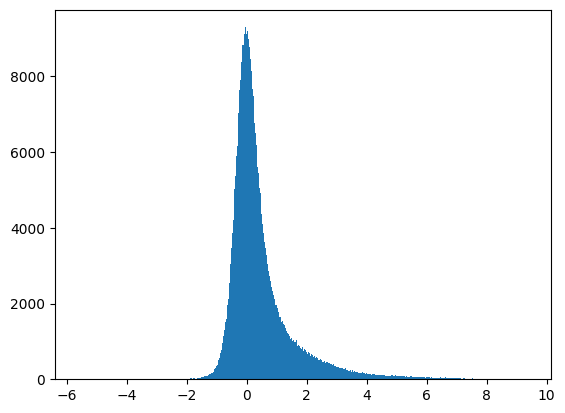

In [5]:
k562_scores = np.array(oracle_data['k562'])
import matplotlib.pyplot as plt

plt.hist(k562_scores, bins = 'auto')
# k562_mid = np.quantile(k562_scores, 0.50)

print(np.quantile(k562_scores, 0.33))
print(np.quantile(k562_scores, 0.66))
# print(k562_mid)

In [6]:
labeling_function = lambda y: 2 if y > 0.5 else 1 if 0.1 < y <= 0.5 else 0

# Apply the lambda function to the 'k562' column
oracle_data['k562'] = oracle_data['k562'].apply(labeling_function)
oracle_data.head()

/tmp/ipykernel_3190736/873295602.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oracle_data['k562'] = oracle_data['k562'].apply(labeling_function)


,Unnamed: 0,chrom,seq,hepg2,k562,sknsh
0,0,chr7,CCTGGTCTTTCTTGCTAAATAAACATATCGTGCATCATCCAGATCT...,0.233601,0,0.047194
1,1,chr1,CATAAAGATGAGGCTTGGCAAAGAACATCTCTCGGTGCCTCCCATT...,0.004565,1,-0.244395
2,2,chr1,CATAAAGCCAATCACTGAGATGACAAGTACTGCCAGGAAAGAAGGC...,0.384537,0,-0.004578
4,4,chr12,CATAAAGGGCTGAACATGCTGTTGAAAAAATGTAGATATAAAAGTT...,1.423444,2,1.335892
5,5,chr12,CATAAAGGGCTGAACATGCTGTTGAAAAAATGTAGATATAAAAGTT...,1.444247,2,0.958289


In [7]:
print((oracle_data['k562'] == 0).sum())
print((oracle_data['k562'] == 1).sum())
print((oracle_data['k562'] == 2).sum())

245115
120882
167982


### Train/Val/Test split by chromosome

In [8]:
import grelu.data.preprocess

train_chroms = None
val_chroms   = ['chr7']
test_chroms  = ['chr13']

df_train, df_val, df_test = grelu.data.preprocess.split(
    oracle_data, 
    train_chroms=train_chroms,
    val_chroms=val_chroms,
    test_chroms=test_chroms,
)

df_train = df_train[['seq', 'k562']]
df_val = df_val[['seq', 'k562']]

Selecting training samples
Keeping 471789 intervals


Selecting validation samples
Keeping 42631 intervals


Selecting test samples
Keeping 19559 intervals
Final sizes: train: (471789, 6), val: (42631, 6), test: (19559, 6)


In [9]:
print(df_train.head())

# num_pos = (df_train['k562'] == 1).sum()
# num_neg = (df_train['k562'] == 0).sum()

                                                 seq  k562
1  CATAAAGATGAGGCTTGGCAAAGAACATCTCTCGGTGCCTCCCATT...     1
2  CATAAAGCCAATCACTGAGATGACAAGTACTGCCAGGAAAGAAGGC...     0
4  CATAAAGGGCTGAACATGCTGTTGAAAAAATGTAGATATAAAAGTT...     2
5  CATAAAGGGCTGAACATGCTGTTGAAAAAATGTAGATATAAAAGTT...     2
6  CATAAAGGTAGACCATATGGTCTAGGAAGCAGAGGACAGCTCAGAA...     0


### Start the training!

In [10]:
model_params = {
    'model_type':'EnformerPretrainedModel',
    'n_tasks': 3,
    'n_transformers': 1,
}

train_params = {
    'task':'multiclass',
    # 'task':'binary',
    'lr':1e-4,
    'logger': 'wandb',
    'batch_size': 512,
    'num_workers': 4,
    'devices': [1],
    'save_dir': 'experiment',
    'optimizer': 'adamw',
    'weight_decay': 1e-1,
    'max_epochs': 20,
    'checkpoint': True,
}

In [11]:

import grelu.data.dataset

train_dataset = grelu.data.dataset.DFSeqDataset(df_train)
val_dataset   = grelu.data.dataset.DFSeqDataset(df_val)

Sequences will be extracted from columns ['seq']


/home/zhaoy183/miniconda3/envs/sequence/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Sequences will be extracted from columns ['seq']


In [12]:
import datetime
unique_id = datetime.datetime.now().strftime("%Y.%m.%d_%H.%M.%S")

run_name = "V2-k562_3class_bs=512_lr=1e-4_EnformerPretrained_block=1_wd=0.1"
run_name += f"_{unique_id}"

run = wandb.init(entity ='zhao-yulai', project="RL-conditioning-DNA_oracles", name=run_name)

# Build model
import grelu.lightning
from grelu.lightning import LightningModel
    
model = LightningModel(model_params=model_params, train_params=train_params)

wandb: Currently logged in as: zhao-yulai. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7


In [13]:
# Train model
trainer = model.train_on_dataset(train_dataset, val_dataset)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/zhaoy183/miniconda3/envs/sequence/lib/python3.12/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Validation DataLoader 0: 100%|██████████| 84/84 [00:04<00:00, 17.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_accuracy          0.28172048926353455
        val_auroc            0.46303591132164
       val_avgprec          0.30879834294319153
        val_loss            1.1039689779281616
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name         | Type                    | Params | Mode 
-----------------------------------------------------------------
0 | model        | EnformerPretrainedModel | 71.5 M | train
1 | loss         | CrossEntropyLoss        | 0      | train
2 | activation   | Softmax                 | 0      | train
3 | val_metrics  | MetricCollection        | 0      | train
4 | test_metrics | MetricCollection        | 0      | train
5 | transform    | Identity                | 0      | train
-----------------------------------------------------------------
71.5 M    Trainable params
0         Non-trainable params
71.5 M    Total params
285.809   Total estimated model params size (MB)


Epoch 8:  93%|█████████▎| 862/922 [01:59<00:08,  7.24it/s, v_num=9246, train_loss_step=0.466, train_loss_epoch=0.468]

/home/zhaoy183/miniconda3/envs/sequence/lib/python3.12/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


### Save the model

In [22]:
# artifact = wandb.Artifact('model', type='model')

# artifact.add_file(trainer.checkpoint_callback.best_model_path, 'k562_2class_model.ckpt')
# run.log_artifact(artifact)

UsageError: Run (u2jp9246) is finished. The call to `log_artifact` will be ignored. Please make sure that you are using an active run.

In [15]:
wandb.finish()

epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▆▅▄▄▃▂▁
train_loss_step,███▇▇▅▆▆▆▆▅▅▅▅▅▅▅▆▄▄▄▅▄▃▃▄▄▃▃▄▃▂▃▂▃▃▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▇███████
val_auroc,▁████████
val_avgprec,▁████████
val_loss,█▁▁▁▁▁▂▂▃
epoch,8
train_loss_epoch,0.46812
train_loss_step,0.38625


***

## 3- Test model

In [16]:
trainer.checkpoint_callback.best_model_path

'experiment/lightning_logs/u2jp9246/checkpoints/epoch=2-step=2766.ckpt'

In [17]:
df_test = df_test[['seq', 'k562']]
test_dataset = grelu.data.dataset.DFSeqDataset(df_test)

best_model = LightningModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
best_model.eval()
best_model.test_on_dataset(test_dataset, devices=[1], num_workers=0)

Sequences will be extracted from columns ['seq']


wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/zhaoy183/miniconda3/envs/sequence/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 0: 100%|██████████| 77/77 [00:05<00:00, 14.45it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.6103590726852417
       test_auroc           0.8196017146110535
      test_avgprec          0.6751596331596375
        test_loss           0.7427815198898315
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,test_accuracy,test_auroc,test_avgprec
0,0.839751,0.855558,0.819582
1,0.281938,0.715966,0.380408
2,0.709387,0.887281,0.825489


### Confusion matrix for each cell type

In [18]:
preds = best_model.predict_on_dataset(test_dataset, devices=[1])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/zhaoy183/miniconda3/envs/sequence/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 77/77 [00:04<00:00, 17.04it/s]


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

from typing import Union, List, Optional, Tuple

def plot_confusion_matrix(
    preds: Union[np.ndarray, pd.DataFrame],
    labels: Union[np.ndarray, pd.DataFrame],
    figsize: Tuple[int, int] = (8, 6),
    **kwargs,
):
    """
    Plot a confusion matrix for the classification labels and calculate macro F1 score.

    Args:
        preds: Model predictions (should be probabilities for multiclass)
        labels: True labels
        figsize: Tuple containing (width, height)
        **kwargs: Additional arguments to pass to confusion matrix display

    Returns:
        Confusion matrix plot and macro F1 score
    """
    if isinstance(preds, pd.DataFrame):
        preds = preds.values
    if isinstance(labels, pd.DataFrame):
        labels = labels.values

    # Reshape predictions and labels to remove extra dimensions
    preds = preds.reshape(preds.shape[0], -1)
    labels = labels.reshape(-1)

    # Convert probabilities to class labels for multiclass classification
    if preds.shape[1] > 1:
        y_pred = preds.argmax(axis=1)
    else:
        # For binary classification, assume threshold of 0.5
        y_pred = (preds > 0.5).astype(int).reshape(-1)
    
    y_true = labels.astype(int)

    # Calculate the F1 score (use 'macro' for multiclass)
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Macro F1 Score: {f1}")

    # Plot the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    fig, ax = plt.subplots(figsize=figsize)
    disp.plot(ax=ax, cmap=plt.cm.Blues, **kwargs)
    plt.show()

In [20]:
# # # Example usage with dummy data:
# dummy_preds = np.random.rand(19559, 1, 1)  # Replace with actual predictions
# dummy_labels = np.random.randint(0, 2, size=(19559, 1, 1))  # Replace with actual labels
# plot_confusion_matrix(dummy_preds, dummy_labels)
# print(dummy_preds.shape)
# print(dummy_labels.shape)

### K562

Macro F1 Score: 0.6093243539413961


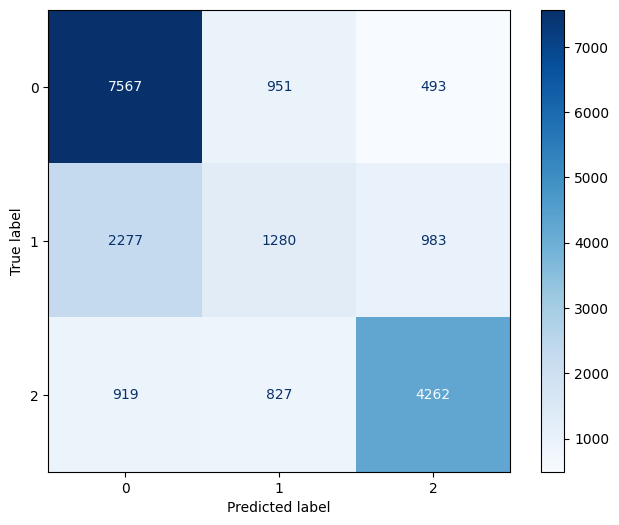

In [21]:
plot_confusion_matrix(preds, test_dataset.labels) # k562